# Data Processing

            Temperature_C  Dew_Point_C  Humidity_%  Speed_kmh  Gust_kmh  \
Date                                                                      
1/1/2021             0.00        -5.44          67        0.0      0.00   
1/1/2021             0.00        -5.67          66        0.0      0.00   
1/1/2021             0.00        -5.78          65        0.0      0.00   
1/1/2021             0.00        -5.89          64        0.0      0.00   
1/1/2021             0.00        -6.22          63        0.0      0.00   
...                   ...          ...         ...        ...       ...   
12/31/2021           3.89         3.67          98        0.0      0.00   
12/31/2021           4.44         4.17          98        0.0      0.00   
12/31/2021           5.06         4.72          98        0.0      0.16   
12/31/2021           5.72         5.33          97        0.0      0.00   
12/31/2021           6.33         5.94          97        0.0      0.00   

            Pressure_hPa

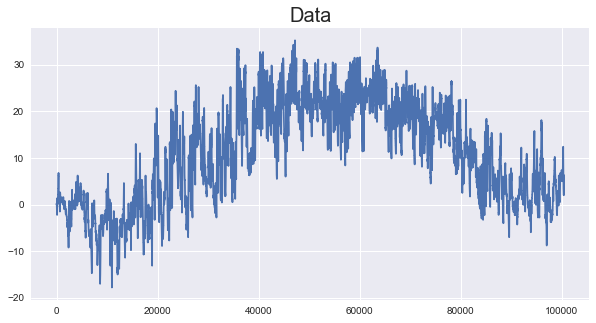

In [9]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
plt.style.use('seaborn')
#tensorflow==2.4.0 keras==2.4.3 python==3.7.10

#data parameters
data_path = 'KNYITHAC52.csv'
test_ratio = 0.1
windows = 6
target_id = 0

#model parameters
lstm_dim = 128
fc_dim = 128

#training parameters
training_state = True
learning_rate=1e-3
dropout = 0.1
batch_size = 256
num_epoch = 1000

#visualization para
test_show_num = 1000

#path para
best_model_LSTM = 'LSTM.h5'

#read data
data = pd.read_csv(data_path, header=0, index_col=0)
data = data.iloc[:,1:]
data = pd.get_dummies(data)
# data['OT'] = [None if value=='#NUM!' else value for i,value in enumerate(data['OT'])]
# data = data.dropna()
# data = data.astype(float)
# data = data[feature_list]
print(data)
print(data.describe())
target = data.iloc[:,target_id].values

#plot
plt.figure(figsize=(10,5))
plt.plot(target)
plt.title("Data",fontsize='20') 
plt.show()
print('\n')



In [10]:
#minmaxscaler
mm_x= MinMaxScaler()
mm_y= MinMaxScaler()
data = mm_x.fit_transform(data)
label = mm_y.fit_transform(np.reshape(target, (-1, 1)))
data[:2], label[:2]

(array([[0.3354717 , 0.27799054, 0.63636364, 0.        , 0.        ,
         0.84006615, 0.        , 0.        , 0.        , 0.01213318,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 1.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ],
        [0.3354717 , 0.27280919, 0.625     , 0.        , 0.        ,
         0.84006615, 0.        , 0.        , 0.        , 0.01213318,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 1.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        ]]),
 array([[0.3354717],
        [0.3354717]]))

In [11]:
def convert_data(data):
    #把数据处理成lstm接受的输入形式
    data = np.array(data)
    cut = round(test_ratio* data.shape[0])
    features_num = data.shape[1]
    lstm_input = []
    lstm_output = []
    for i in range(len(data)-windows):
        lstm_input.append(data[i:i+windows,:])
        lstm_output.append(data[i+windows,target_id])
    lstm_input=np.array(lstm_input)
    lstm_output=np.array(lstm_output)  
    x_train,y_train,x_test,y_test=\
    lstm_input[:-cut,:,:],lstm_output[:-cut:],lstm_input[-cut:,:,:],lstm_output[-cut:]
    print('x_train.shape',x_train.shape)
    print('x_test.shape',x_test.shape)
    print('y_train.shape',y_train.shape)
    print('y_test.shape',y_test.shape)
    return x_train, x_test, y_train, y_test, features_num

x_train, x_test, y_train, y_test, features_num = convert_data(data)

x_train.shape (90346, 6, 26)
x_test.shape (10039, 6, 26)
y_train.shape (90346,)
y_test.shape (10039,)


# Evaluate Function

In [12]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt

def mape(y_true, y_pred):    
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n*100
    return mape

def easy_result(y_train, y_train_predict, train_index, model_index, show_num):
    #画图进行展示
    y_train_predict=np.reshape(y_train_predict, (-1,1))  
    y_train_predict= mm_y.inverse_transform(y_train_predict)
    y_train_predict=y_train_predict[:,0]
    y_train=np.reshape(y_train, (-1,1))  
    y_train=mm_y.inverse_transform(y_train)
    y_train=y_train[:,0]

    plt.figure(figsize=(10,5))
    plt.plot(y_train[-show_num:])
    plt.plot(y_train_predict[-show_num:])
    plt.legend(('real', 'predict'),fontsize='15')
    plt.title("%s Data"%train_index,fontsize='20') #添加标题
    plt.show()
    print('\n')

    plot_begin,plot_end=min(min(y_train),min(y_train_predict)),max(max(y_train),max(y_train_predict))
    plot_x=np.linspace(plot_begin,plot_end,10)
    plt.figure(figsize=(5,5))
    plt.plot(plot_x,plot_x)
    plt.plot(y_train,y_train_predict,'o')
    plt.title("%s Data"%train_index,fontsize='20') #添加标题
    plt.show()

    #输出结果
    print('%s上的MAE/RMSE/MAPE/R^2'%train_index)
    print(mean_absolute_error(y_train, y_train_predict))
    print(np.sqrt(mean_squared_error(y_train, y_train_predict) ))
    print(mape(y_train, y_train_predict) )
    print(r2_score(y_train, y_train_predict))

    pred_data = np.vstack([y_train, y_train_predict])
    pred_data = pd.DataFrame(pred_data).T
    pred_data.to_csv('Result_%s_%s.csv'%(model_index ,train_index))
    
def history2plot(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(loss))
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Train and Val Loss')
    plt.show()

# LSTM

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 26)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               79360     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 96,001
Trainable params: 96,001
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
318/318 [==============================] - 7s 17ms/step - loss: 0.0485 - accuracy: 5.5749e-05 - val_loss:

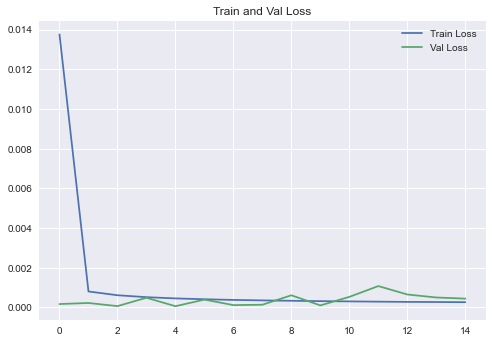

In [13]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input,LSTM,Dropout,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

def lstm_model():
    inputs=Input(shape=x_train.shape[1:])
    model = LSTM(units=lstm_dim, return_sequences=False)(inputs)
    model = Dropout(dropout)(model)
    model = Dense(fc_dim, activation="relu", use_bias=True)(model)
    dense = Dense(1, activation="relu", use_bias=True)(model)
    model = Model(inputs=inputs, outputs=dense)
    print(model.summary())
    model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse',metrics=['accuracy'])
    return model

def myTrain(myModel, training_state, Path):
    es_patience = 10
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=es_patience)
    cp = keras.callbacks.ModelCheckpoint(filepath = Path, monitor='val_loss', save_best_only=True)
    if training_state==True:
        history = myModel.fit(x= x_train,
                            y= y_train,
                            batch_size=batch_size,
                            epochs=num_epoch,
                            verbose=1,
                            callbacks=[es, cp],
                            validation_split=0.1)
        history2plot(history)
    myModel.load_weights(Path) 
    return myModel

myModel = lstm_model()
myModel = myTrain(myModel, training_state, best_model_LSTM)

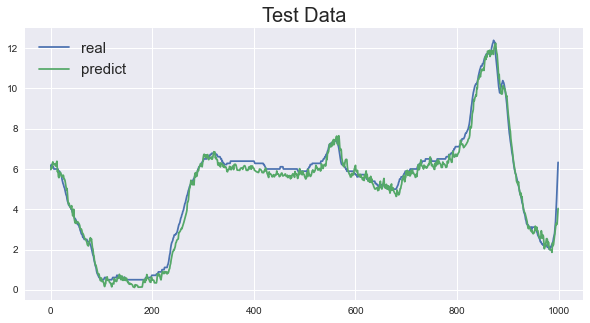

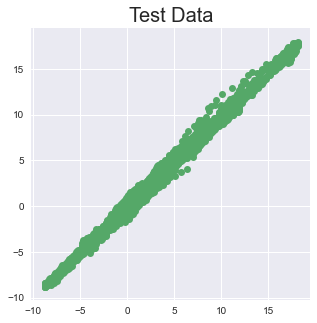

Test上的MAE/RMSE/MAPE/R^2
0.2561166528271846
0.3422763241942838
inf
0.9940218345502073


C:\Users\Pengyu\miniconda3\envs\tf24\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


In [14]:
y_test_predict=myModel.predict(x_test)
easy_result(y_test,y_test_predict,'Test','LSTM',test_show_num)